# Abstract

*Machine Learning and Artificial Intelligence are now being used by various industries to solve complex business and operations problem. ML & AI applications has multiple applications, ranging from impacting our daily life with product recommendations to large industrial applications such as fraud detection.* Machine Learning with Limited Data: Given relatively limited historical weather reports such as those available for [The San Francisco International Airport](https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:23234/detail) up to a certain day, predict whether it will rain on the next day at that location.<br>

*This abstract explains **ML application on weather predictions**. Weather conditions around the world change rapidly and continuously. From agriculture to industry, from traveling to daily commuting, we are dependent on weather forecasts heavily. Weather predictions are a difficult task and are performed with large complex models of physics. The models are generally run on hundreds of nodes in a large High-Performance Computing (HPC) environment which consumes a large amount of energy and data.* <br>

*This abstract explains how ML and data-centric approach can be applied for weather predictions with limited data. Here we present a weather prediction technique with limited data that utilizes historical observations from a **single weather station**(San Francisco International Airport) to train a simple machine learning model and predict detection of rain tomorrow. It's a simple Machine learning approach which can be applied at different problems to provide intelligent models.*

In [1]:
import matplotlib.pyplot as plt
import plotly.plotly as py  # when using pandas, matplotlib with plotly
import cufflinks as cf
import plotly.graph_objs as go
import ipywidgets as widgets
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls  # using matplotlib
import pickle
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)a
import warnings
import seaborn as sns  # visualization tool
import os
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from scipy import stats
from statsmodels import robust
from scipy.stats import kurtosis, skew
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, normalize, StandardScaler
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_columns', 200)
pd.set_option("display.max_rows", 5000)
warnings.filterwarnings(action='ignore')  #once
# import plotly as py # When using python
%matplotlib inline
init_notebook_mode(connected=True)
cf.go_offline()

/Users/shamanu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


# Introduction

In this study, we collected the data from NOAA for The San Francisco International Airport. Once we collect the data, we see that the Data is available at three levels 1) **Hourly Level** 2) **Daily Level** 3) **Monthly Level**. 

we have downloaded data for last 5.5 years for the complete analysis. We have prepared the analytical dataset at a *daily level* and combining it with *few hourly level features*. After the inital data prepration, dataset is split in training and test set. However, the target variable is always the next day rain prediction for San Francisco. It is a classification problem where target variables have two classes **Yes:1** and **No:0**

Analytical Dataset Range: 1st Jan 2014 to 30th June 2019

In [2]:
# San Francisco
#weath = pd.read_csv('/users/shamanu/documents/san/weather_san.csv')
weath = pd.read_csv('/users/shamanu/documents/san/san_5years.csv')
#print("Shape: {}".format(weath.shape))
# weath.head()
day_col = ["STATION", "DATE", "REPORT_TYPE", "SOURCE", "DailyAverageDewPointTemperature",
           "DailyAverageDryBulbTemperature", "DailyAverageRelativeHumidity", "DailyAverageSeaLevelPressure",
           "DailyAverageStationPressure", "DailyAverageWetBulbTemperature", "DailyAverageWindSpeed",
           "DailyCoolingDegreeDays", "DailyDepartureFromNormalAverageTemperature", "DailyHeatingDegreeDays",
           "DailyMaximumDryBulbTemperature", "DailyMinimumDryBulbTemperature", "DailyPeakWindDirection",
           "DailyPeakWindSpeed", "DailyPrecipitation", "DailySustainedWindDirection",
           "DailySustainedWindSpeed", "DailyWeather", "HeavyFog",
           "Sunrise", "Sunset", "TStorms"
           ]
hour_col = ["STATION", "DATE", "REPORT_TYPE", "HourlyAltimeterSetting", "HourlyDewPointTemperature",
            "HourlyDryBulbTemperature", "HourlyPrecipitation", "HourlyPresentWeatherType", "HourlyPressureChange",
            "HourlyPressureTendency", "HourlyRelativeHumidity", "HourlySeaLevelPressure", "HourlySkyConditions",
            "HourlyStationPressure", "HourlyVisibility", "HourlyWetBulbTemperature", "HourlyWindDirection",
            "HourlyWindGustSpeed", "HourlyWindSpeed"]

# Dataset Summary & Prepration 
After importing the weather data for San Francisco from NOAA, we observed Dataset has a shape of **(65652,124)**, it includes features for both daily and hourly level. We created a daily level data after including the selective features from hourly data for analysis and modelling.<br>
At large, Features are at Hourly/Daily level and can be classified in following categories

* **Humidity** - Average Relative Humidity
* **Temperature** - Dew Point Temp, Sea Level Temp, DryBulb Temp, WetBulb Temp
* **Pressure** - Sea Level Pressure, Station Level Pressure
* **Precipitation** - Amount of Precipitation, Weather Conditions
* **Wind** - Average Wind Speed, Wind Direction

In [3]:
''' filters
SOD - For Daily Level Data
SOM - For Monthly Level Data
FM-12 Hourly Level Data'''
# Daily Level Data
df = weath[weath.REPORT_TYPE == 'SOD  '][day_col]
#print ("Shape: {}".format(df.shape))
df['DateTime'] = pd.to_datetime(df.DATE)
df['DATE'] = df.DateTime.dt.date
# df.head()

# Freezing the data
startdate = pd.to_datetime("2019-06-30").date()
# print(startdate)
df = df[df.DATE <= startdate]
#print ("Shape: {}".format(df.shape))
# df.head()

## Hourly Data
df_hour = weath[weath.REPORT_TYPE == 'FM-15'][hour_col]
#print ("Shape: {}".format(df_hour.shape))
df_hour['DateTime'] = pd.to_datetime(df_hour.DATE)

df_hour['DATE'] = df_hour.DateTime.dt.date
df_hour['HOUR'] = df_hour.DateTime.dt.hour
#df_hour.head()

#Pivoted the hourly data to bring that in our Daily data format
piv_h = df_hour.pivot_table(index = 'DATE', columns = 'HOUR', values = ['HourlyRelativeHumidity','HourlyWindSpeed',
                                                                       'HourlyWindGustSpeed'])
piv_h.columns = piv_h.columns.map('{0[0]}_{0[1]}'.format)
df = df.merge(piv_h[['HourlyRelativeHumidity_22','HourlyWindSpeed_22','HourlyWindGustSpeed_22']], on ='DATE')
# print ("Shape: {}".format(df.shape))
# print("min_date{}".format(df.DATE.min()))
# print("max_date{}".format(df.DATE.max()))
#df.head()

## Define Target Variable/ Modelling Goal

**Rain Today**: Initially we will create the RainToday feature. We used two existing features to create it, Daily Weather & Daily Precipitation

1. Daily Weather - As per the data documents Daily Weather features has information about the weather conditions. Identiefied three Rain relted AU Codes **RA:Rain** **DZ:Drizzle** **TS:Thunderstorm** and labeled them as 1
2. Replaced Daily recipitation traces **T** with 0.004
3. Daily Precitiation greater then 0 labeled as 1


**Rain Tomm**: The target variable is always the prediction 1 or 0 rain tommorow for San Francisco. For that we shifted the **Rain Today** feature by -1 step, so that we can predict the rain a day ahead. <br>
Frequency of 0 and 1 of rain tomorrow after the target variable creation in complete data 

In [4]:
#df['Rain'] = df['DailyWeather'].apply(lambda x: 1 if 'RA' in x else 0)
#df['Rain'] = df[df['DailyWeather'].str.contains("RA") == True]

df['DailyPrecipitation'] = df['DailyPrecipitation'].replace({'T': 0.004})
df['DailyPrecipitation'] = pd.to_numeric(df['DailyPrecipitation'])
'''vectorized way of str contains to create a new column'''

df.loc[df['DailyWeather'].str.contains("RA|DZ|TS", na = False), 'RainToday'] = 1
df['RainToday'].fillna(0, inplace = True)

#print("Target Feature Shaep : \n {}".format(df['RainToday'].value_counts()))
#df.head()

#df[(df.RainToday == 0) & (df.DailyPrecipitation > 0)].shape
df['RainToday'] = np.where((df.RainToday==0) & (df.DailyPrecipitation >0), 1,df.RainToday)

#1. 64 Observation where precipittaion greater then 0 : 41 were Traces Converting these values to Rain too

#print(df['RainToday'].value_counts())
##Creation of RainTomm Column
df['RainTomm'] = df['RainToday'].shift(-1)
print(df['RainTomm'].value_counts())

0.0    1562
1.0     444
Name: RainTomm, dtype: int64


In [5]:
num_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]
#print(num_cols)
#Separating columns
target_col=["RainTomm"]
Id_col=['DateTime']
time_col=['Year','Month','Day']
drop_col= ['STATION', 'SOURCE','HeavyFog','Sunrise','Sunset','TStorms']

# EDA & Preprocessing
## Univariate Analysis

Some of the variables are supposed to be highly coorelated as we have multiple temperature, pressure and other variables. So instead of jumping directly to individual feature analysis and relationship with target feature. We plotted numeric variables correlational plot first.

Observations:

* **Daily Average Dewpoint Temperature** is highly coorelated with **Daily Average Wet Bulb Temperature** and **Daily minimum Dry Bulb Temperature**
* **Daily Average SeaLevel Pressure** and **Daily Average Station Pressure** is highly correlated
* **Daily Average Wind Speed** and **Daily Sustained Wind Speed** are highly coorelated

We can take out highly coorelated variables from the analysis, as they are multicollinear and not right for statistical algorithms

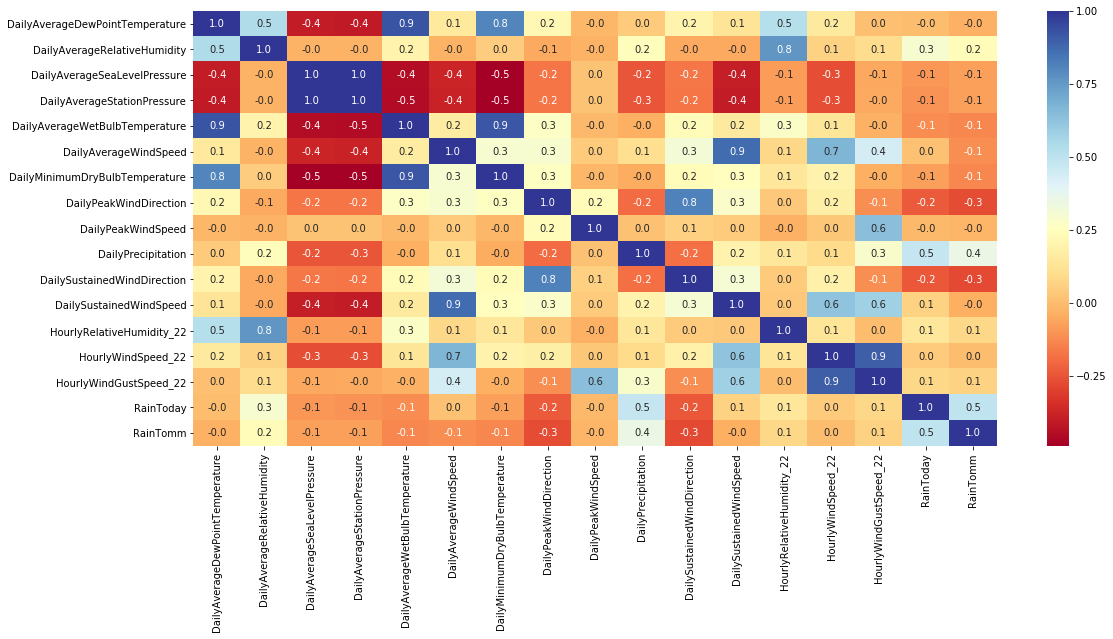

In [6]:
plt.figure(figsize=(18,8))
sns.heatmap(df[num_cols].drop(drop_col, axis = 1).corr(), annot=True, fmt=".1f", cmap="RdYlBu");

**Distribution**: Histogram plot of all numeric variables, all of our numeric predictors look like normally distributed, except the Daily Precipitation. This again confirm the normality assumption of Statistical algorithm

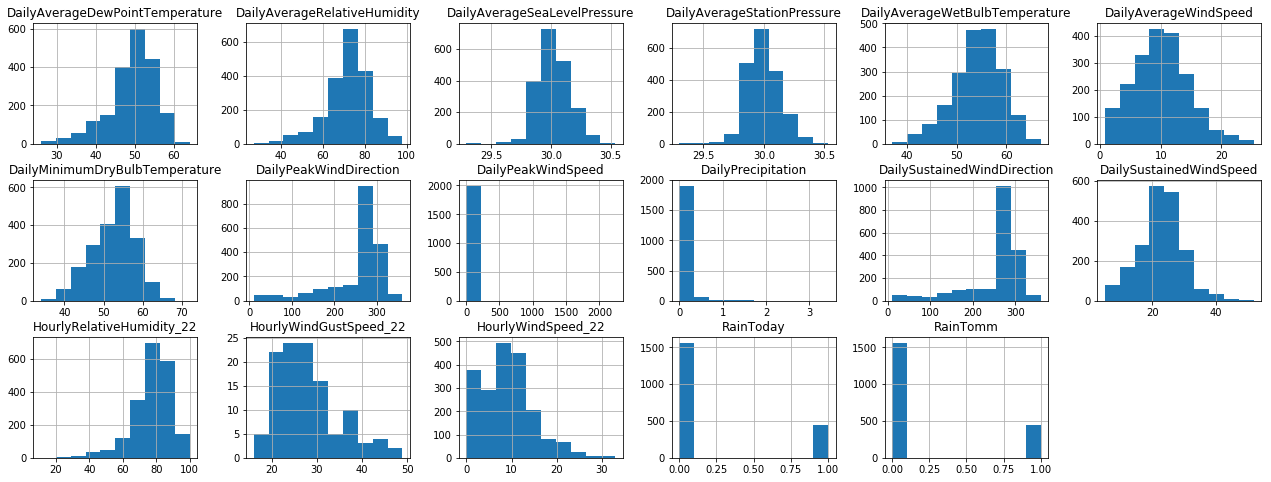

In [7]:
df[list(set(num_cols)-set(drop_col))].hist(figsize=(22, 8), layout=(3, 6));

## Bi-variate Analysis

We also created new time related variables for our classification model. Using time related variables in regression/classification model can catch the seasonality effect and also improve the results. So, we created time related variables Rain **Year, Month & Date** <br>

**Year Bar Plot**: Frequency of Yes and No Rain Tomorrow, across the years. Since the bar heights are not varying across the years, it is not looking like a promising feature.

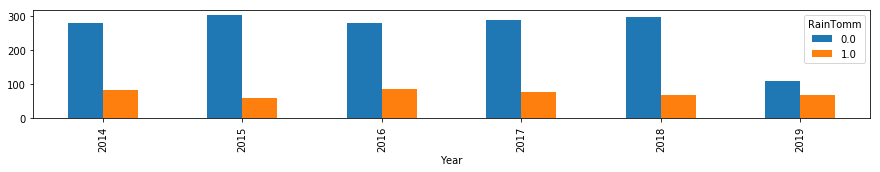

In [8]:
#plt.style.use('seaborn-talk')
df['Year'] = df.DateTime.dt.year
df['Month'] = df.DateTime.dt.month
df['Day'] = df.DateTime.dt.day
pd.crosstab(df.Year,df.RainTomm).plot(kind ='bar', figsize=(15,2));

**Month Bar Plot**: Frequency of Yes and No Rain Tomorrow, across the months. Because, the 0 and 1 bar heights are varying across the months, month should come out as one important feature.

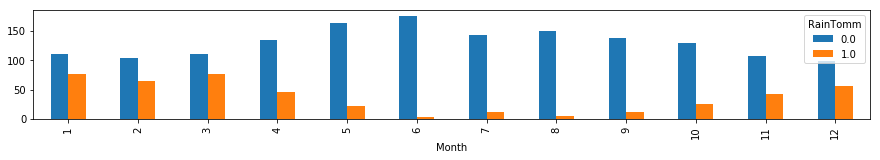

In [9]:
pd.crosstab(df.Month,df.RainTomm).plot(kind ='bar',figsize=(15,2));

**Day Bar Plot**: Frequency of Yes and No Rain Tomorrow, across the days given in any month or year. As per the varying bar heights of Rain across the days, Day might come out as important feature.

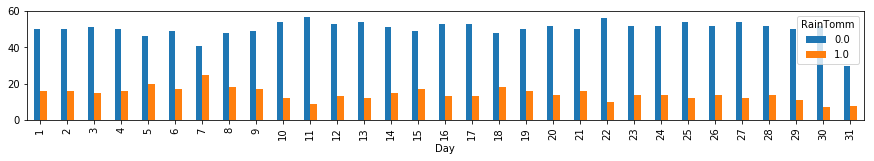

In [10]:
pd.crosstab(df.Day,df.RainTomm).plot(kind ='bar',figsize=(15,2));

**Daily Avg Relative Humidity**: As per the plots, we can see that box plot of 1(rainy day tomm) has different distribution as compared to 0. It has high mean, high median as compared to non rainy days tomm. Avg Humidity can come out as important feature

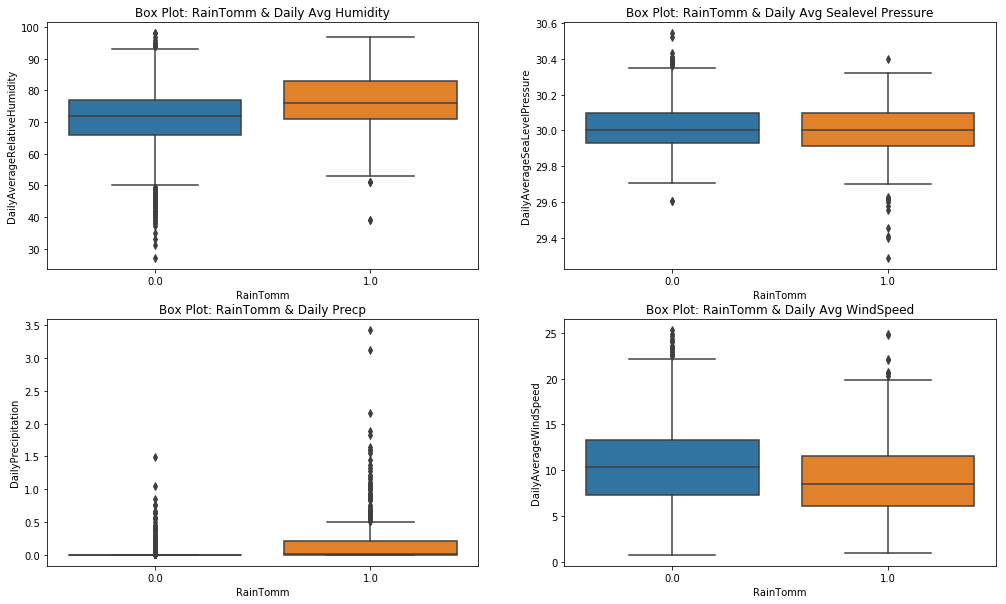

In [39]:
fig,[(ax1, ax2), (ax3, ax4)] = plt.subplots(2,2,figsize=(17,10)) # not add axs while defining 
## plotting
sns.boxplot(x = df.RainTomm, y = df.DailyAverageRelativeHumidity, ax = ax1).set_title('Box Plot: RainTomm & Daily Avg Humidity');
sns.boxplot(x = df.RainTomm, y = df.DailyAverageSeaLevelPressure, ax = ax2).set_title('Box Plot: RainTomm & Daily Avg Sealevel Pressure');

sns.boxplot(x = df.RainTomm, y = df.DailyPrecipitation, ax = ax3).set_title('Box Plot: RainTomm & Daily Precp');
sns.boxplot(x = df.RainTomm, y = df.DailyAverageWindSpeed, ax = ax4).set_title('Box Plot: RainTomm & Daily Avg WindSpeed');

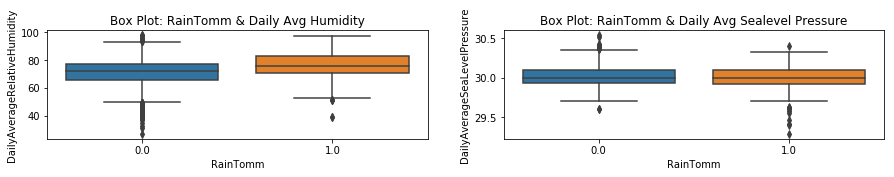

In [40]:
#plt.style.use('fivethirtyeight')
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,2))
sns.boxplot(x = df.RainTomm, y = df.DailyAverageRelativeHumidity, ax = ax1).set_title('Box Plot: RainTomm & Daily Avg Humidity');
sns.boxplot(x = df.RainTomm, y = df.DailyAverageSeaLevelPressure, ax = ax2).set_title('Box Plot: RainTomm & Daily Avg Sealevel Pressure');

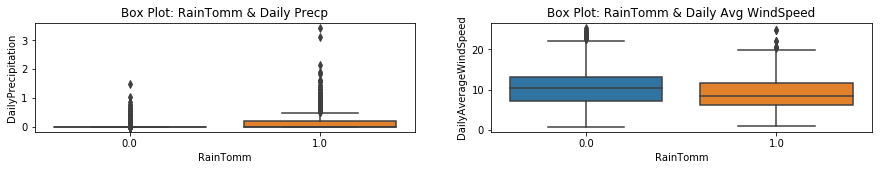

In [42]:
#plt.style.use('fivethirtyeight')
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,2))
sns.boxplot(x = df.RainTomm, y = df.DailyPrecipitation, ax = ax1).set_title('Box Plot: RainTomm & Daily Precp');
sns.boxplot(x = df.RainTomm, y = df.DailyAverageWindSpeed, ax = ax2).set_title('Box Plot: RainTomm & Daily Avg WindSpeed');

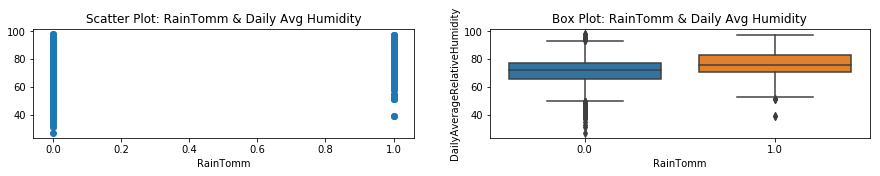

In [11]:
#plt.style.use('fivethirtyeight')
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,2))
ax1.scatter(df.RainTomm, df.DailyAverageRelativeHumidity);
ax1.title.set_text('Scatter Plot: RainTomm & Daily Avg Humidity')
ax1.set_xlabel('RainTomm')
sns.boxplot(x = df.RainTomm, y = df.DailyAverageRelativeHumidity, ax = ax2).set_title('Box Plot: RainTomm & Daily Avg Humidity');

**Daily Avg Wind Speed**: Daily Average Windspeed doesn't show high difference in distribution on Rain & Non Rainy Day Tomorrow <br>

**Hourly Wind Speed 10pm**: Our added feature Hourly Wind Speed 10pm doesnt show high difference in distribution on Rain & Non Rainy Day Tomorrow

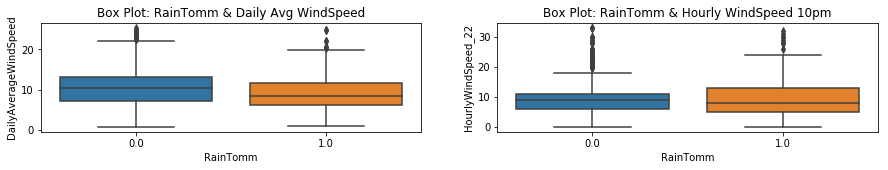

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,2))
sns.boxplot(x = df.RainTomm, y = df.DailyAverageWindSpeed, ax = ax1).set_title('Box Plot: RainTomm & Daily Avg WindSpeed');
sns.boxplot(x = df.RainTomm, y = df.HourlyWindSpeed_22, ax = ax2).set_title('Box Plot: RainTomm & Hourly WindSpeed 10pm');

**Daily Avg Dew Point Temperature**: Dew Point has similar distribution on 0 and 1. It explains the less chances of Dew point as an important predictor <br>

**Daily Avg Sea Level Pressure**: As per the plot, if Sea Level Pressure is low today there are high chances of Rain Tomorrow. Daily Avg Sea Level Pressure can come out as an important feature

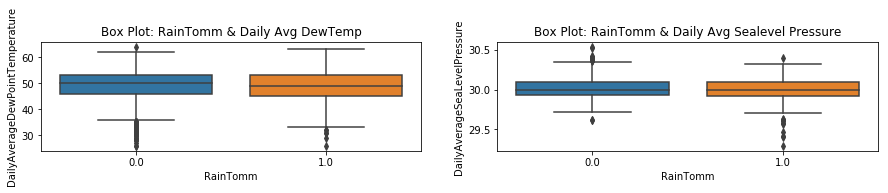

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,2))
sns.boxplot(x = df.RainTomm, y = df.DailyAverageDewPointTemperature, ax = ax1).set_title('Box Plot: RainTomm & Daily Avg DewTemp');
sns.boxplot(x = df.RainTomm, y = df.DailyAverageSeaLevelPressure, ax = ax2).set_title('Box Plot: RainTomm & Daily Avg Sealevel Pressure');

**Daily Sustained Wind Direction & Daily Peak Wind Direction** : As per the plot, both the features has almost same distribution with response variable. So only of them should be considered for modelling exercise

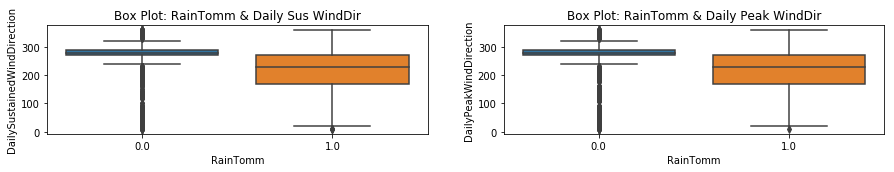

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,2))
sns.boxplot(x = df.RainTomm, y = df.DailySustainedWindDirection, ax = ax1).set_title('Box Plot: RainTomm & Daily Sus WindDir');
sns.boxplot(x = df.RainTomm, y = df.DailyPeakWindDirection, ax = ax2).set_title('Box Plot: RainTomm & Daily Peak WindDir');

**Daily Precipitation**: It is skewed and has very few observations towards the higher side. As per the box plot, high precipitation today will have higher probability for rain tomorrow. Again, it should come out as an important fetaure

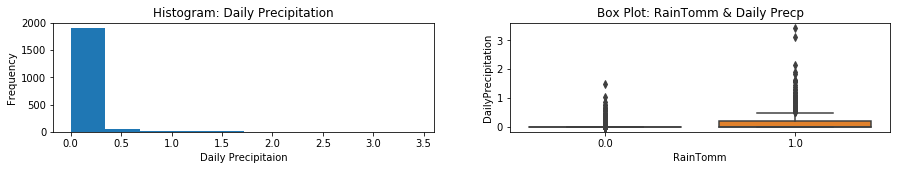

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,2))
df['DailyPrecipitation'].plot(kind ='hist',ax = ax1, title ='Histogram: Daily Precipitation')
ax1.set_xlabel('Daily Precipitaion')
sns.boxplot(x = df.RainTomm, y = df.DailyPrecipitation, ax = ax2).set_title('Box Plot: RainTomm & Daily Precp');

In [16]:
# data_train = data.iloc[:891]
# data_test = data.iloc[891:]
df = pd.get_dummies(df, columns=['Year', 'Month', 'Day'], drop_first=True)
# df.head(100)

predictors = ['DailyAverageWindSpeed', 'DailyAverageRelativeHumidity','DailyAverageDewPointTemperature',
              'DailyAverageSeaLevelPressure','HourlyRelativeHumidity_22',
              'DailyPrecipitation','DailySustainedWindDirection', 'RainToday']  #HourlyWindGustSpeed_21 #RainToday

year_col = [col for col in df if col.startswith('Year')]
month_col = [col for col in df if col.startswith('Month')]
day_col = [col for col in df if col.startswith('Day')]

response = ['RainTomm']
#print(X[X.isnull().any(axis=1)]) # To see any nan rows
#df[predictors + year_col + month_col+ day_col+ response + Id_col].isnull().sum()

we converted the *categorical features in the dataset such as month, day and wind direction,using a technique called ‘One Hot Encoding’* We perform this conversion prior to the separation
of training and test data. This is because, in both training and test
data, we need the same number of feature variables. <br>

Most of our modelling features has no missing values. Only 30 observations missing in few features. So not assuming on the type of missing value and removing them from our analytical dataset<br>

Before and after shape of the analytical data after the removal of missing values and selecting important features

In [17]:
df_c = df[Id_col + predictors + month_col + day_col +response].dropna()
print("Shape before the nans removal: {} Shape after the nans removal: {}".format(df.shape,df_c.shape))

Shape before the nans removal: (2007, 78) Shape after the nans removal: (1975, 51)


# Machine Learning Predictions
In this study, as the predicted outcomes are binary values, we have used classification techniques. In addition, we show comparison of statistical algorithms Logistic regression and ensembling technique GBM. <br>
Also compared the results after handling the imbalanced data problem, because as we know the *results obtained by ML methods are only as good as the data used to train*.<br> 
**Precison**, **Recall** and **AUC** are considered as the performance measures because its a imbalanced data and we are considering correct prediction of 1 is equally or more important than correct prediction of 0

## Train Test Split
Two ways the create the Train Test split: 

* Randomly split the data 
* Split the data based on time
    
In the second approach we may lose the significance of latest data in the learning model, which will increase the bias error in my classification model.<br>
After the random data selection we have train and test data shape 

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, \
    precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score


X = df_c[predictors + month_col + day_col]
y = df_c[response]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=100)

print("train set shape: {}".format(X_train.shape))
print("test set shape: {}".format(X_test.shape))

train set shape: (1382, 49)
test set shape: (593, 49)


Count of 1 and 0 observations in the test dataset are following

In [19]:
pred_feats = X_train.columns
y_test['RainTomm'].value_counts()

0.0    468
1.0    125
Name: RainTomm, dtype: int64

## Model Fit & Predict
### Logistic Reression

It is a Statistical classification algorithm. Here we are fitting a default logistic regression model on train set and predicted on the testset. As we discussed, we are using Recall, Precision and AUC as performance measure for the model.<br>

Accuracy of logistic regression with default threshold's are following. No sign of overfitting.

In [20]:
logreg = LogisticRegression(random_state = 100)
logreg.fit(X_train, y_train)
#print(logreg.fit(X_train, y_train))

print("logistic model train accuracy :", logreg.score(X_train, y_train))
print("logistic model test accuracy :", logreg.score(X_test, y_test))
y_pred = logreg.predict(X_test)


logistic model train accuracy : 0.8502170767004341
logistic model test accuracy : 0.8465430016863407


Confusion metric and perfomance scores of Logistic Regression model on the test data are following:

In [21]:
# confusion_matrix = confusion_matrix(y_test, y_pred)
# print(confusion_matrix)
pred_set = pd.DataFrame(y_pred, columns = ['pred'])
pred_set['test'] = y_test.reset_index(drop = True)
#pred_set.head()
pd.crosstab(pred_set.test, pred_set.pred)

pred  0.0  1.0
test          
0.0   448   20
1.0    71   54

**Accuracy: 85% , Recall: 43%, Precision: 73%**

### GBM

GBM constructs a forward stage-wise additive model to reduce the error with building trees. So unlike Random forest, GBM is an ensembling technique. <br>
Below are GBM model accuracy on train & test dataset. No sign of overfitting.

In [22]:
params = {'n_estimators': 100,'learning_rate': 0.01, 'loss': 'deviance', 'random_state': 100,'subsample':0.9}

gbm = GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)
#print(gbm.fit(X_train, y_train))


print("Regression train accuracy :", gbm.score(X_train, y_train))
print("Regression test accuracy :", gbm.score(X_test, y_test))
y_pred = gbm.predict(X_test)

Regression train accuracy : 0.8502170767004341
Regression test accuracy : 0.8532883642495784


Confusion metric and perfomance scores of GBM model on the test data are following:

In [23]:
pred_gbm = pd.DataFrame(y_pred, columns = ['pred'])
pred_gbm['test'] = y_test.reset_index(drop = True)
#pred_set.head()
pd.crosstab(pred_gbm.test, pred_gbm.pred)

pred  0.0  1.0
test          
0.0   459    9
1.0    78   47

**Accuracy: 85% , Recall: 38%, Precision: 84%**

GBM Has high Precision but low Recall as compared to Logistic Regreesion. ROC Curve and AUC for Logistic Regression and GBM are 0.70. Both are performing equally well.

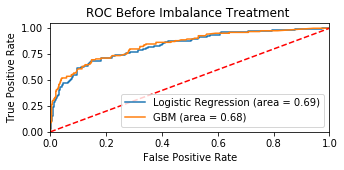

In [24]:
logit_roc_auc = roc_auc_score(pred_set.test, pred_set.pred)
gbm_roc_auc = roc_auc_score(pred_gbm.test, pred_gbm.pred)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
fpr_g, tpr_g, thresholds_g = roc_curve(y_test, gbm.predict_proba(X_test)[:, 1])
plt.figure(figsize=(5, 2))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr_g, tpr_g, label='GBM (area = %0.2f)' % gbm_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Before Imbalance Treatment ')
plt.legend(loc="lower right")
plt.show()

### Improvements: Imbalanced Data

ML & Statistical algorithms are built to minimize errors. Since the probability of instances belonging to the majority class is significantly high in imbalanced data set, the algorithms are much more likely to classify new observations to the majority class. To solve this problem, we can either increase the minority class or decrease the majority class observations. <br>

In our problem since we already have limited data, we will increase the minority class observations.<br>

In our training dataset, following is the distribution of our target variable **Rain Tomm**, before any SMOTE application

In [25]:
y_train['RainTomm'].value_counts()

0.0    1080
1.0     302
Name: RainTomm, dtype: int64

In [26]:
smt = SMOTE(random_state=100)
X_train, y_train = smt.fit_sample(X_train, y_train)

After the imbalanced data treatment, we used smote to upsample the minority class, frequency of target variable **Rain Tomm** is following:

In [27]:
pd.Series(y_train).value_counts()

0.0    1080
1.0    1080
dtype: int64

#### Logistic Regression after Imbalanced data treatment
Let's see the reuslts of logistic regression after the imbalance value treatment.<br>

Following are the Confusion metric of Test datset after SMOTE. Recall and Precision on test set are also improved after SMOTE

In [28]:
logreg = LogisticRegression(random_state = 100)
logreg.fit(X_train, y_train)

#print("logistic train accuracy :", logreg.score(X_train, y_train))
#print("logistic test accuracy :", logreg.score(X_test, y_test))
y_pred = logreg.predict(X_test)

In [29]:
pred_set = pd.DataFrame(y_pred, columns = ['pred'])
pred_set['test'] = y_test.reset_index(drop = True)
#pred_set.head()
pd.crosstab(pred_set.test, pred_set.pred)

pred  0.0  1.0
test          
0.0   391   77
1.0    41   84

**Accuracy: 87% , Recall: 67%, Precision: 52%**

#### GBM after Imbalanced data treatment
Following are the Confusion metric of Test datset after SMOTE. Recall and Precision of GBM on test set are improved after SMOTE application

In [30]:
params = {'n_estimators': 100,'learning_rate': 0.01, 'loss': 'deviance', 'random_state': 100,'subsample':0.9}

gbm = GradientBoostingClassifier(**params)
gbm.fit(X_train, y_train)
#print(gbm.fit(X_train, y_train))
# print("Regression train accuracy :", gbm.score(X_train, y_train))
# print("Regression test accuracy :", gbm.score(X_test, y_test))
y_pred = gbm.predict(X_test)

In [31]:
pred_gbm = pd.DataFrame(y_pred, columns = ['pred'])
pred_gbm['test'] = y_test.reset_index(drop = True)
#pred_set.head()
pd.crosstab(pred_gbm.test, pred_gbm.pred)

pred  0.0  1.0
test          
0.0   429   39
1.0    55   70

**Accuracy: 88% , Recall: 56%, Precision: 64%**

After Imbalanced data treatment **Accuracy, Precision and Recall** all has **increased by 4%**, significant jump from the earlier results. <br> 
ROC Curve and AUC for Logistic Regression and GBM after imbalanced data treatment are following:

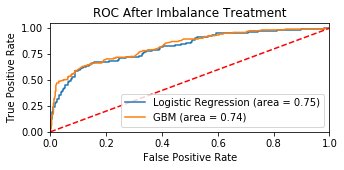

In [32]:
logit_roc_auc = roc_auc_score(pred_set.test, pred_set.pred)
gbm_roc_auc = roc_auc_score(pred_gbm.test, pred_gbm.pred)

fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
fpr_g, tpr_g, thresholds_g = roc_curve(y_test, gbm.predict_proba(X_test)[:,1])

plt.figure(figsize=(5,2))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr_g, tpr_g, label='GBM (area = %0.2f)' % gbm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC After Imbalance Treatment')
plt.legend(loc="lower right")
plt.show()

*Coefficients of Logististic Regression models*;
    *Green* is for Positive coefficients
    *Red* is for negative coefficients, y axis is the cefficient value for respective features

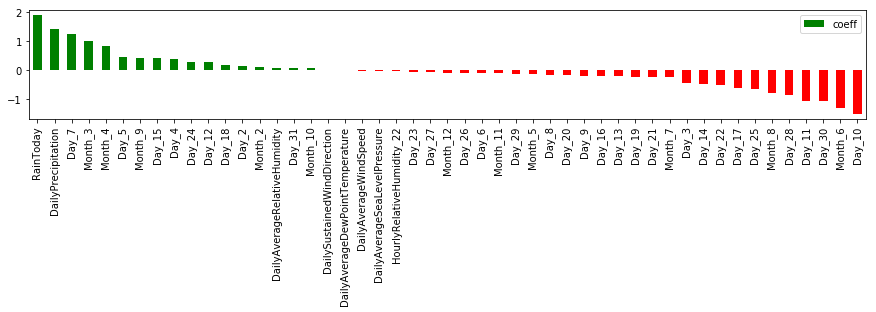

In [33]:
coeff = logreg.coef_.ravel()
coef_sum = pd.DataFrame(coeff, index = predictors+month_col+day_col, columns =['coeff']).sort_values('coeff',ascending = False)
#coef_sum
#plt.figure(figsize =(12,10))
coef_sum.plot(kind ='bar', color = [np.where(coef_sum['coeff']>0,'g','r')], figsize=(15,2));

GBM Provides relative importance as compared to logistic regression, so it won't have any negative coefficients

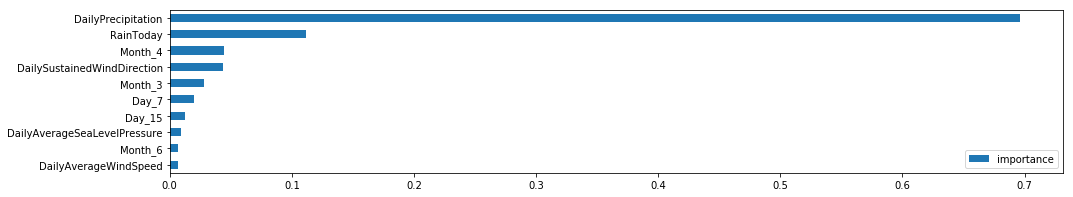

In [34]:
feat_imp = pd.DataFrame(gbm.feature_importances_, 
                               index = pred_feats, columns = ['importance']).nlargest(10,'importance').sort_values('importance',ascending = True)

# original importance
feat_imp.plot(kind = 'barh', figsize= (16,3));

As expected during our analysis *Daily Precipitaion, Months, Relative Humidity* came out as important features

# Conclusion & Next Steps

In this study, we presented a data centric approach to utilize machine learning techniques to provide weather forecasts. We validated the results using simple train test split and using performance measures Recall, Precision & AUC. I'ts a Simple machine Machine learning approach which can provide intelligent models.

As next steps, we can further improve the model performance and scope by using following

* Time based train test split 
* Parameter optimization on respective algorithms 
* Further Feature engineering to create more predictor features
* For Time series we can also use multivariate LSTM Model, who exhibits excellenet performance on sequential data 
* We can also make a more location generic model, if we will have a dataset for that

<h2> References </h2>

[https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) <br>

[https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) <br>

[https://medium.com/james-blogs/handling-imbalanced-data-in-classification-problems-7de598c1059f](https://medium.com/james-blogs/handling-imbalanced-data-in-classification-problems-7de598c1059f)
